In [128]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import sim, utils, init, evolve, redist
plt.style.use("seaborn")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [151]:
s = sim.Sim(
    initial_wealth=init.constant(value=0.5),
    evolve_func=evolve.normal_change,
    redist_func=lambda x:x)

In [152]:
s.step(100)

100%|██████████| 100/100 [00:01<00:00, 88.47it/s]


In [153]:
s.wealths

,person,time_step,wealth
0,0,0,0.500000
1,1,0,0.500000
2,2,0,0.500000
3,3,0,0.500000
4,4,0,0.500000
...,...,...,...
995,995,100,0.086816
996,996,100,0.414439
997,997,100,0.303032
998,998,100,0.263303


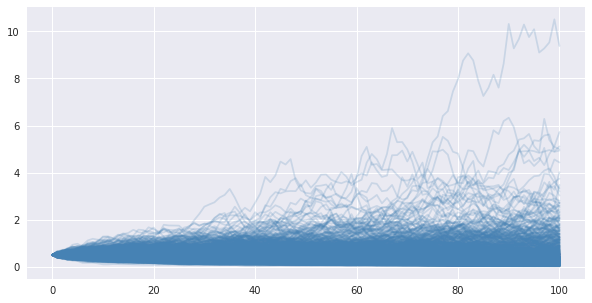

In [154]:
fig, ax = s.wealths_over_time()
# fig.savefig("./Images/first_sim_wealths.png", bbox_inches = "tight")

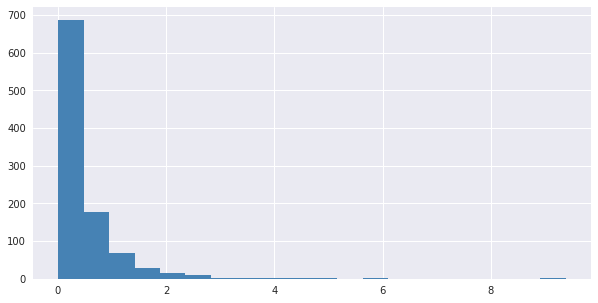

In [155]:
fig, ax = s.hist(time_step = s.time_step)
# fig.savefig("./Images/first_sim_wealths_hist.png", bbox_inches = "tight")

In [156]:
groups = utils.group_stats(s.wealths)

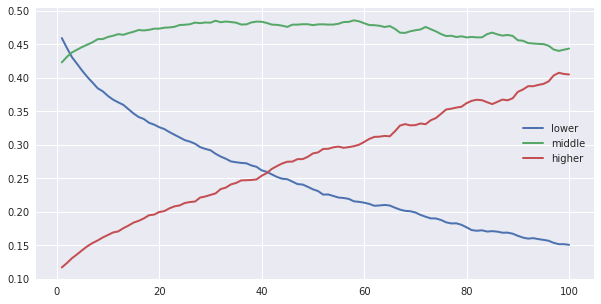

In [157]:
fig, ax = plt.subplots(figsize=(10, 5))
for c in ["lower", "middle", "higher"]:
    group_data = groups[(groups["group"] == c) & (groups.time_step > 0)].sort_values("time_step")
    ax.plot(group_data.time_step, group_data.group_pct, linewidth = 2, label = c)
ax.legend();
# fig.savefig("./Images/first_sim_wealths_class.png", bbox_inches = "tight")